In [1]:
import pandas as pd
import xarray as xr 
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    job_name="Climt1",          # --job-name
    cores=48,                   # 24 cores per node
    processes=4,                # One process per task
    memory="400GB",             # --mem
    walltime="04:00:00",        # --time
    queue="med",                # --partition
    log_directory=".",          # Logs will be saved to the current directory
)

/home1/nalex2023/.local/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33205 instead
  warnings.warn(


In [2]:
from dask.distributed import Client


cluster.scale(jobs=2)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.42.239.61:33205/status,
Dashboard: http://10.42.239.61:33205/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.42.239.61:34687,Workers: 0
Dashboard: http://10.42.239.61:33205/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [13]:
cluster.close()
client.shutdown()

In [3]:
manus_met_data_fol = '/home2/nalex2023/Datasets/LSB_OUTS/met_arm_hourly_2000_2013.nc'

manus_airt = xr.open_mfdataset(manus_met_data_fol)['temp_mean']



/home1/nalex2023/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [4]:
manus_airt_max = manus_airt.groupby('time.month').mean()



In [ ]:
manus_airt_max = manus_airt_max.chunk({'date':1000})

In [144]:
manus_airt_min = manus_airt.groupby('time.month').min()#.chunk({'date':1000})

In [6]:
manus_airt_max_computed = manus_airt_max.compute()

In [146]:
manus_airt_min_computed = manus_airt_min.compute()


In [41]:
manus_airt_min_computed['date'] = manus_airt_min_computed.date.astype('datetime64[ns]')

In [42]:
manus_airt_max_computed['date'] = manus_airt_max_computed.date.astype('datetime64[ns]')

In [43]:
monthly_max_means = manus_airt_max_computed.groupby('date.month').mean()

monthly_min_means = manus_airt_min_computed.groupby('date.month').mean()


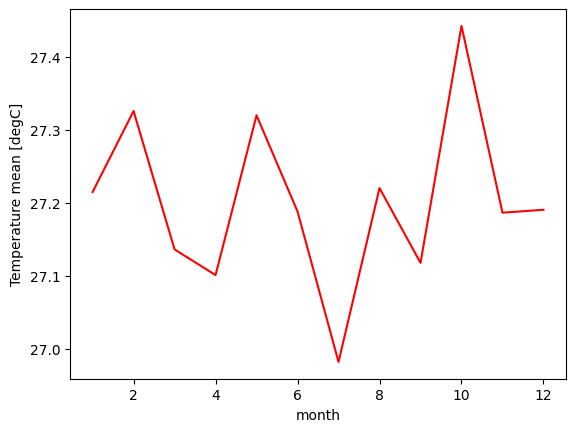

In [7]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()

manus_airt_max_computed.plot(ax=ax,color='red')
#manus_airt_min_computed.plot(ax=ax,color='blue')

In [48]:
sst_ds

<xarray.Dataset> Size: 481MB
Dimensions:  (lat: 720, lon: 1440, time: 29, zlev: 1)
Coordinates:
  * lat      (lat) float32 3kB -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * time     (time) datetime64[ns] 232B 2000-02-01T12:00:00 ... 2000-02-29T12...
  * zlev     (zlev) float32 4B 0.0
Data variables:
    anom     (time, zlev, lat, lon) float32 120MB dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    err      (time, zlev, lat, lon) float32 120MB dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    ice      (time, zlev, lat, lon) float32 120MB dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
    sst      (time, zlev, lat, lon) float32 120MB dask.array<chunksize=(1, 1, 720, 1440), meta=np.ndarray>
Attributes: (12/37)
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...
    source:                     ICOADS, NCEP_GTS, GSFC_ICE, NCEP_ICE, Pathfin...
    id:                         oisst-avhrr-v02r01.20000201.nc
    naming_authority:           gov.noaa.ncei
    summary:                    NOAAs 1/4-degree Daily Optimum Interpolation ...
    cdm_data_type:              Grid
    ...                         ...
    metadata_link:              https://doi.org/10.25921/RE9P-PT57
    ncei_template_version:      NCEI_NetCDF_Grid_Template_v2.0
    comment:                    Data was converted from NetCDF-3 to NetCDF-4 ...
    sensor:                     Thermometer, AVHRR
    Conventions:                CF-1.6, ACDD-1.3
    references:                 Reynolds, et al.(2007) Daily High-Resolution-...

In [19]:
test = xr.open_dataset('/home2/nalex2023/Datasets/sst_datasets/sst_final/oisst_time_mean2000_2015.nc')

In [8]:
test_sst = xr.open_dataset('/home2/nalex2023/Datasets/sst_datasets/oisst_mon_mea/sst.mon.mean.nc')

In [9]:
test_sst_nearest = test_sst.sel(lat=-2.3,lon=147.1,method='nearest').sel(time=slice('2000','2013'))

In [10]:
monthly_means = test_sst_nearest.groupby('time.month').mean()

In [11]:
monthly_means

<xarray.Dataset> Size: 152B
Dimensions:  (month: 12)
Coordinates:
    lat      float32 4B -2.375
    lon      float32 4B 147.1
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (month) float32 48B 29.7 29.38 29.4 29.66 ... 29.68 29.95 29.83
Attributes:
    Conventions:    CF-1.5
    title:          NOAA/NCEI 1/4 Degree Daily Optimum Interpolation Sea Surf...
    institution:    NOAA/National Centers for Environmental Information
    source:         NOAA/NCEI https://www.ncei.noaa.gov/data/sea-surface-temp...
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    version:        Version 2.1
    comment:        Reynolds, et al.(2007) Daily High-Resolution-Blended Anal...

Text(0.5, 1.0, 'Monthly Max/Min Air Temperatures (TWP-MET) \n SST (OISST) at Manus Island (2000-2014)')

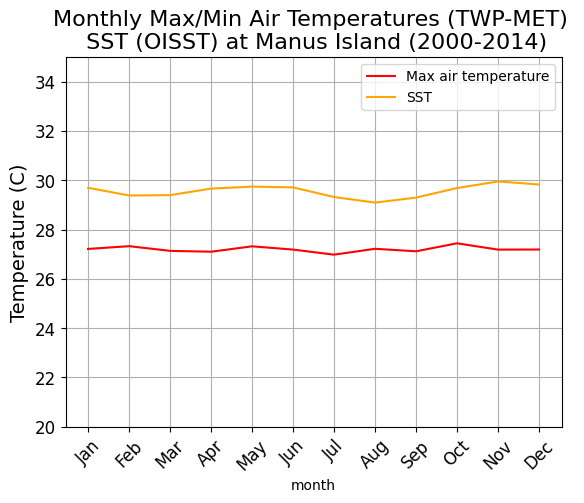

In [12]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
"""
monthly_max_means.plot(ax=ax,color='red',label='Max air temperature')
monthly_min_means.plot(ax=ax,color='blue',label='Min air Temperature')
"""

manus_airt_max_computed.plot(ax=ax,color='red',label='Max air temperature')
#manus_airt_min_computed.plot(ax=ax,color='blue',label='Min air Temperature')

monthly_means.sst.plot(ax=ax,color='orange',label='SST')

ax.set_ylim(20,35)

ax.legend()
ax.set_ylabel('Temperature (C)',size=14)
ax.grid()
# change the x-axis ticks to show month names
ax.set_xticks(range(1, 13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May',
                    'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
                    'Nov', 'Dec'], rotation=45)

ax.tick_params(axis='both', which='major', labelsize=12)
#ax.set_title('Monthly Max/Min Air Temperatures (TWP-MET) and SST (OISST) at Manus Island (2000-2014)', size=16)
# add next line to the title text 
ax.set_title('Monthly Max/Min Air Temperatures (TWP-MET) \n SST (OISST) at Manus Island (2000-2014)', size=16)